In [1]:
import torch

words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}


# build the dataset

def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)


import random

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [2]:
Xtrain, Ytrain

(tensor([[ 0,  0,  0],
         [ 0,  0, 24],
         [ 0, 24, 20],
         ...,
         [14, 11,  3],
         [11,  3,  0],
         [ 3,  0, 13]]),
 tensor([24, 20,  7,  ...,  0, 13,  0]))

In [34]:
import torch

g = torch.Generator().manual_seed(42)


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn(fan_in, fan_out, generator=g) / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class BatchNorm:
    def __init__(self, n_in, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.n_in = n_in
        self.gamma = torch.ones(n_in)
        self.beta = torch.zeros(n_in)
        self.running_mean = torch.zeros(n_in)
        self.running_var = torch.ones(n_in)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps) ** 0.5
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10
n_hidden = 100
block_size = 3
vocab_size = 27
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].W *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5 / 3
            if layer.b is not None:
                layer.b.zero_()

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"number of parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_(True)

number of parameters: 47497


In [4]:
C

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
         -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00],
        [-3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
          7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01],
        [-7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
          1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02],
        [-2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01,
          1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01],
        [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
          2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01],
        [ 7.8024e-02,  5.2581e-01, -4.8799e-01,  1.1914e+00, -8.1401e-01,
         -7.3599e-01, -1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01],
        [-9.7807e-02,  1.8446e+00, -1.1845e+00,  1.3835e+00,  1.4451e+00,
          8.5641e-01,  2.2181e+0

In [35]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for step in range(max_steps):
    # sample a batch
    i = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    xb, yb = Xtrain[i], Ytrain[i]
    # forward pass
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = torch.nn.functional.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if step < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    if step % 1000 == 0:
        print(f"step = {step}, loss = {loss.item()}")
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])
    lossi.append(loss.item())

step = 0, loss = 3.293452501296997
step = 1000, loss = 2.3359875679016113
step = 2000, loss = 2.3435680866241455
step = 3000, loss = 2.2717673778533936
step = 4000, loss = 2.453786849975586
step = 5000, loss = 2.186310052871704
step = 6000, loss = 1.9684038162231445
step = 7000, loss = 2.1850621700286865
step = 8000, loss = 2.247283935546875
step = 9000, loss = 2.3354382514953613
step = 10000, loss = 2.2601664066314697
step = 11000, loss = 1.6540578603744507
step = 12000, loss = 2.2735257148742676
step = 13000, loss = 1.930068016052246
step = 14000, loss = 2.0828559398651123
step = 15000, loss = 2.314941167831421
step = 16000, loss = 1.9817626476287842
step = 17000, loss = 2.422407865524292
step = 18000, loss = 1.859904408454895
step = 19000, loss = 1.965527057647705


layer 2 (    linear): mean = -0.001277, std = 0.633831, saturated: 4.63%
layer 5 (    linear): mean = -0.000293, std = 0.653992, saturated: 4.59%
layer 8 (    linear): mean = 0.006815, std = 0.658656, saturated: 4.09%
layer 11 (    linear): mean = -0.003760, std = 0.672091, saturated: 3.12%
layer 14 (    linear): mean = 0.018788, std = 0.651229, saturated: 1.91%


Text(0.5, 1.0, 'Histogram of activations')

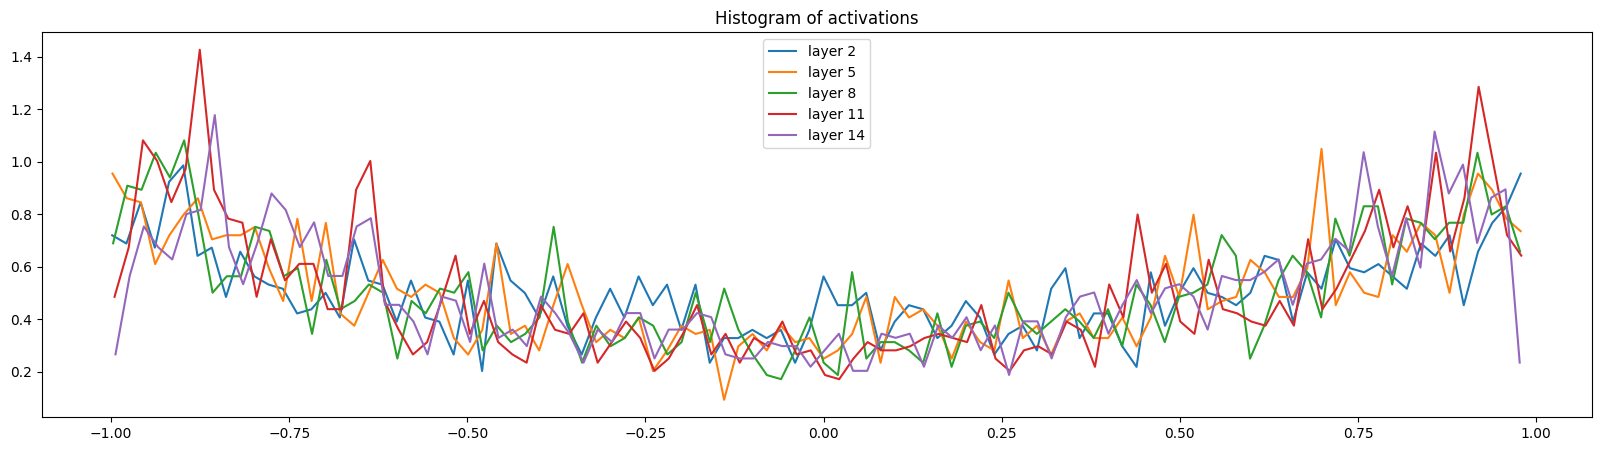

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean = %f, std = %f, saturated: %.2f%%' % (
        i, 'linear', t.mean(), t.std(), (abs(t) > 0.97).float().mean().item() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer %d' % i)
plt.legend(legends)
plt.title('Histogram of activations')

layer 2 (    linear): mean = 0.000000, std = 0.003368, saturated: 0.00%
layer 5 (    linear): mean = 0.000000, std = 0.003128, saturated: 0.00%
layer 8 (    linear): mean = 0.000000, std = 0.003207, saturated: 0.00%
layer 11 (    linear): mean = -0.000000, std = 0.003062, saturated: 0.00%
layer 14 (    linear): mean = -0.000024, std = 0.003418, saturated: 0.00%


Text(0.5, 1.0, 'Histogram of gradients')

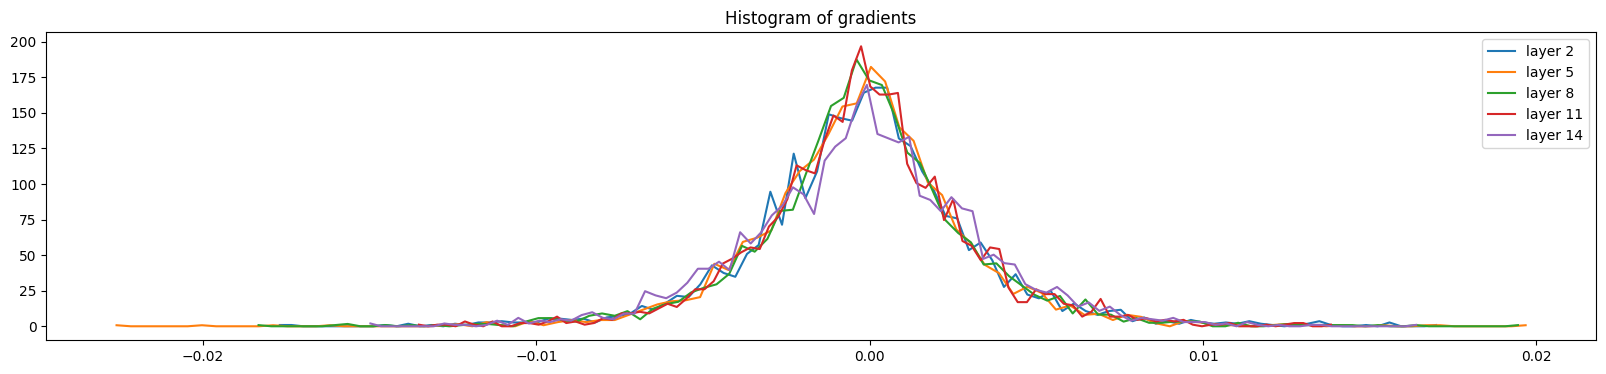

In [37]:
# visualize histograms 
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean = %f, std = %f, saturated: %.2f%%' % (
        i, 'linear', t.mean(), t.std(), (abs(t) > 0.97).float().mean().item() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer %d' % i)
plt.legend(legends)
plt.title('Histogram of gradients')

layer 0  weight (  (27, 10)): mean = -0.000000, std = 0.010448, grad:data 3.744153e-03
layer 1  weight ( (30, 100)): mean = -0.000307, std = 0.009043, grad:data 5.786622e-03
layer 5  weight ((100, 100)): mean = -0.000042, std = 0.006206, grad:data 2.048054e-01
layer 9  weight ((100, 100)): mean = -0.000058, std = 0.006018, grad:data 2.256792e-02
layer 13  weight ((100, 100)): mean = -0.000022, std = 0.005838, grad:data -5.899086e-02
layer 17  weight ((100, 100)): mean = -0.000049, std = 0.005488, grad:data 1.009230e-02
layer 21  weight ( (100, 27)): mean = 0.000000, std = 0.019849, grad:data 2.417019e-01


Text(0.5, 1.0, 'Histogram of gradients')

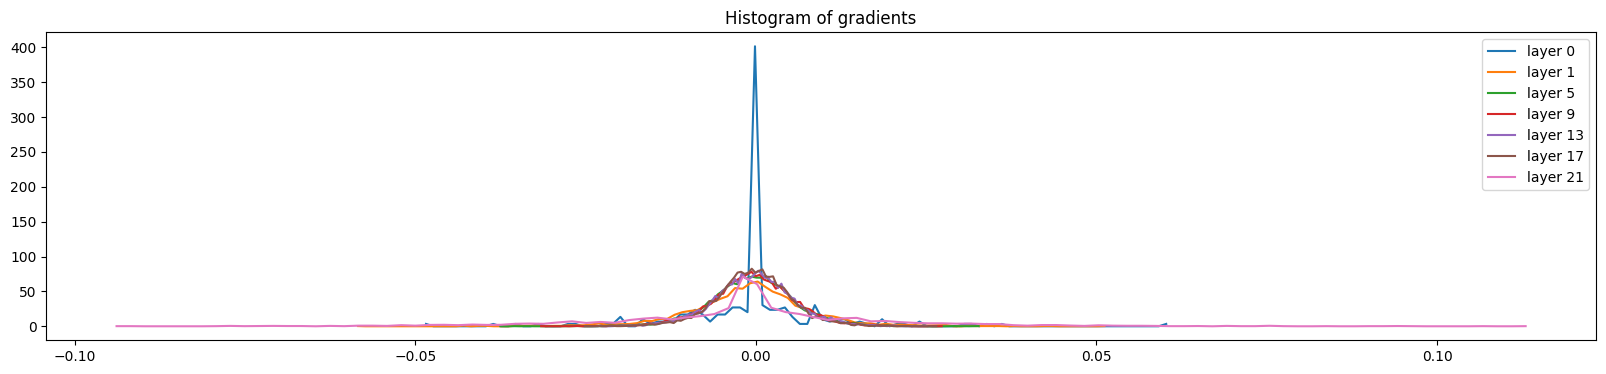

In [38]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('layer %d  weight (%10s): mean = %f, std = %f, grad:data %e' % (
        i, tuple(t.shape), t.mean(), t.std(), (t / p).mean()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer %d' % i)
plt.legend(legends)
plt.title('Histogram of gradients')

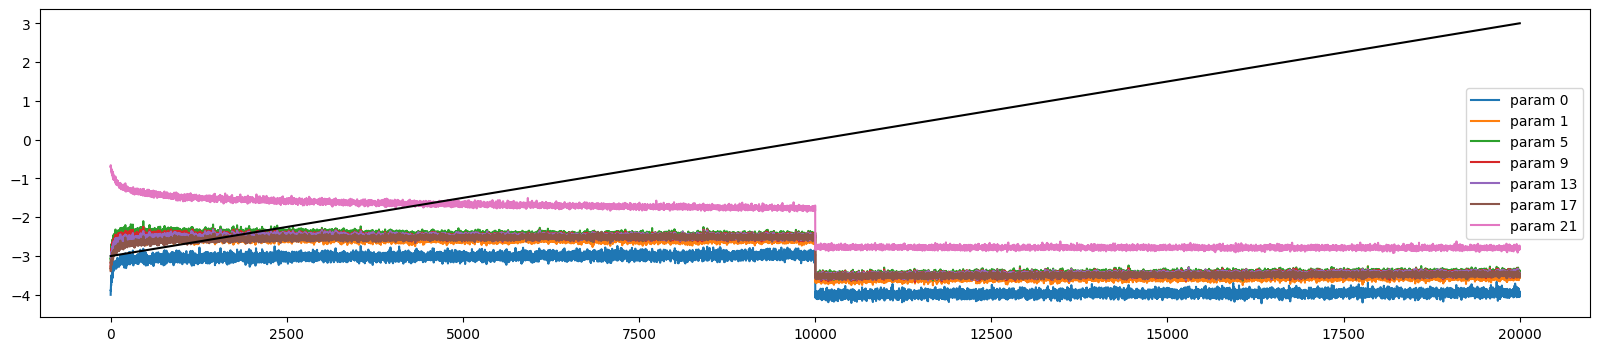

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, 3], 'k')
plt.legend(legends)